In [1]:
import re
import nltk
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import optimizers
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from keras.layers import ReLU , Softmax
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder , LabelEncoder
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score

In [2]:
dataset = pd.read_csv("Language_Detection.csv")

nltk.download('wordnet')
nltk.download('stopwords')

print(dataset.head())

                                                Text Language
0  de spons behoort tot het geslacht haliclona en...    Dutch
1   –  richard plantagenet campbell temple-nugent...    Dutch
2   –  richard plantagenet temple-nugent-brydges-...    Dutch
3   groot-kronig  bloem per steel de trompet is l...    Dutch
4   poeticus meestal  bloem per steel bloemblaadj...    Dutch


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
corpus = []
lemmatizer = WordNetLemmatizer()

for i in range(9996):
    words = dataset["Text"][i].split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in set(stopwords.words(dataset["Language"][i].lower()))]
    words = " ".join(words)
    corpus.append(words)

In [4]:
vectorizer = TfidfVectorizer()

Y = dataset.iloc[: , 1]

encoder = LabelEncoder()
Y_Encoded = encoder.fit_transform(Y)
Y = keras.utils.to_categorical(Y_Encoded , num_classes = 10)

X = vectorizer.fit_transform(corpus)

print(X.get_shape())
print(encoder.classes_)

(9996, 108973)
['Dutch' 'English' 'French' 'Indonesian' 'Portuguese' 'Romanian' 'Russian'
 'Spanish' 'Swedish' 'Turkish']


In [5]:
X_Train , X_Test , Y_Train , Y_Test = train_test_split(X , Y , test_size = 0.20 , random_state = 20)
X_Train , X_Val , Y_Train , Y_Val = train_test_split(X_Train , Y_Train , test_size = 0.18 , random_state = 20)

X_Val = X_Val.toarray()
X_Test = X_Test.toarray()
X_Train = X_Train.toarray()

X_Val = X_Val.reshape((X_Val.shape[0] , X_Val.shape[1] , 1))
X_Test = X_Test.reshape((X_Test.shape[0] , X_Test.shape[1] , 1))
X_Train = X_Train.reshape((X_Train.shape[0], X_Train.shape[1], 1))

print(X_Val.shape)
print(X_Test.shape)
print(X_Train.shape)

(1440, 108973, 1)
(2000, 108973, 1)
(6556, 108973, 1)


In [6]:
input_shape = (X_Train.shape[1] , X_Train.shape[2])

models = keras.Sequential()

models.add(keras.layers.Conv1D(filters = 20 , kernel_size = 6 , activation = ReLU() , strides = 2 , input_shape = input_shape))
models.add(keras.layers.Flatten())
models.add(keras.layers.Dense(units = 32 , activation = ReLU()))
models.add(keras.layers.Dense(units = 64 , activation = ReLU()))
models.add(keras.layers.Dense(units = 10 , activation = Softmax()))

models.summary()

models.compile(loss = "categorical_crossentropy" , optimizer = optimizers.Adam(amsgrad = True) , metrics = ["accuracy"])
history = models.fit(X_Train , Y_Train , validation_data = (X_Val , Y_Val) , batch_size = 32 , epochs = 16)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 54484, 20)         140       
                                                                 
 flatten (Flatten)           (None, 1089680)           0         
                                                                 
 dense (Dense)               (None, 32)                34869792  
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 34872694 (133.03 MB)
Trainable params: 34872694 (133.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/16
2

In [7]:
models.save("Project_DL.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


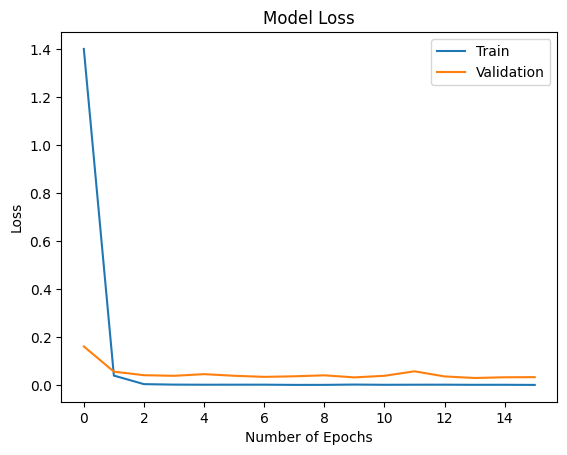

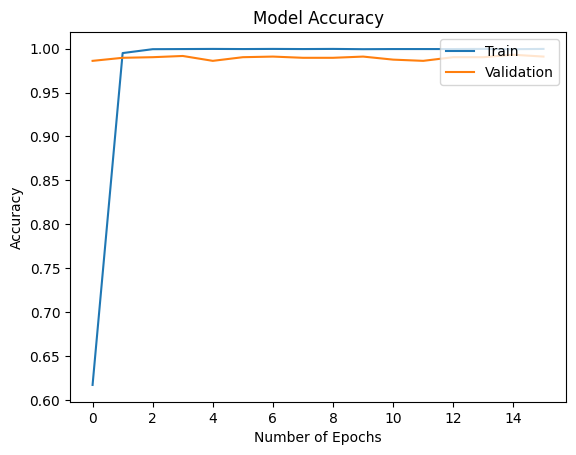

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.ylabel('Loss')
plt.title('Model Loss')
plt.xlabel('Number of Epochs')
plt.legend(['Train' , 'Validation'] , loc = 'upper right')
plt.show()

print("\n")

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])


plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Number of Epochs')
plt.legend(['Train' , 'Validation'] , loc = 'upper right')
plt.show()

In [9]:
Y_Pred = models.predict(X_Test)
Y_Test_Arg = np.argmax(Y_Test , axis = 1)
Y_Pred_Classes = np.argmax(Y_Pred , axis = 1)
print("Classification Report for Test Data : " + "\n")
print(classification_report(Y_Test_Arg , Y_Pred_Classes))

print("Test Accuracy : " , accuracy_score(Y_Test_Arg , Y_Pred_Classes))

63/63 [==============================] - 2s 37ms/step
Classification Report for Test Data : 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       209
           1       0.98      0.99      0.99       190
           2       0.99      0.98      0.99       200
           3       0.97      1.00      0.98       208
           4       0.97      0.98      0.98       198
           5       1.00      0.98      0.99       198
           6       1.00      0.99      0.99       200
           7       0.99      0.96      0.98       187
           8       0.99      1.00      0.99       199
           9       1.00      1.00      1.00       211

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000

Test Accuracy :  0.989


In [10]:
print("Confusion Matrix for Test Data : " + "\n")
print(confusion_matrix(Y_Test_Arg , Y_Pred_Classes))

Confusion Matrix for Test Data : 

[[208   0   0   1   0   0   0   0   0   0]
 [  0 189   0   1   0   0   0   0   0   0]
 [  1   0 197   1   0   0   0   1   0   0]
 [  0   0   0 207   1   0   0   0   0   0]
 [  0   0   0   1 195   0   0   1   1   0]
 [  0   2   0   1   0 195   0   0   0   0]
 [  0   0   0   1   0   0 198   0   1   0]
 [  0   1   1   0   5   0   0 180   0   0]
 [  0   0   0   0   0   0   0   0 199   0]
 [  0   1   0   0   0   0   0   0   0 210]]


In [11]:
sent = "buna mă numesc bhavya și sunt aici să-ți fac un cadou de ziua ta"   # Any sentence in mentioned languages after removing all punctuations and capital letters

sent = sent.strip()
sent = sent.lower()

words_new = sent.split()
words_new = [lemmatizer.lemmatize(word) for word in words_new if word not in set(stopwords.words())]
words_new = " ".join(words_new)

predict_word = vectorizer.transform([words_new])

predict_word = predict_word.toarray()
predict_word = predict_word.reshape((predict_word.shape[0] , predict_word.shape[1] , 1))
print(predict_word.shape)

predicted = models.predict(predict_word)

class_max = predicted.max()
index = list(predicted[0]).index(class_max)

print("The predicted language is : " , (encoder.classes_)[index])

(1, 108973, 1)
1/1 [==============================] - 0s 42ms/step
The predicted language is :  Romanian


In [16]:
dataset_2 = pd.read_csv("Language Detection.csv")
print(dataset_2)


                                                   Text  Language
0     [102]​ Proyectos como Wikipedia, Susning.nu o ...   Spanish
1     [104]​ Debido a su considerable popularidad, e...   Spanish
2                       [105]​ Su popularidad fue poca.   Spanish
3     [106]​ No obstante, ha sido criticada por ser ...   Spanish
4     [107]​[108]​[109]​ Wikipedia tiene una serie d...   Spanish
...                                                 ...       ...
7497  clima este ecuatorială cu căderi abundente de ...  Romanian
7498  clima în aravá este deșertică subtropicală can...  Romanian
7499  clement din alexandria posibil să fi considera...  Romanian
7500  clement alexandrinul c  dhr în lucrarea sa "hy...  Romanian
7501  clădirile actualei mănăstiri și renovarea bise...  Romanian

[7502 rows x 2 columns]


In [17]:
corpus_new = []

for i in range(7502):
    words_new = dataset_2["Text"][i].split()
    words_new = [lemmatizer.lemmatize(word) for word in words_new if word not in set(stopwords.words(dataset_2["Language"][i].lower()))]
    words_new = " ".join(words_new)
    corpus_new.append(words_new)

In [148]:
Y_New = dataset_2.iloc[: , 1]

encoder_new = LabelEncoder()
Y_Encoded_New = encoder_new.fit_transform(Y_New)
Y_New = keras.utils.to_categorical(Y_Encoded_New , num_classes = 10)

X_New_Trans = vectorizer.transform(corpus_new)

print(X_New_Trans.get_shape())
print(encoder_new.classes_)

(7502, 108973)
['Dutch' 'English' 'French' 'Indonesian' 'Portuguese' 'Romanian' 'Russian'
 'Spanish' 'Swedish' 'Turkish']


In [149]:
predict_word_new = pd.DataFrame(X_New_Trans.toarray())
sample_X = predict_word_new.sample(n = 2000 , random_state = 20)
sample_Y = pd.DataFrame(Y_New).sample(n = 2000 , random_state = 20)

Y_New = sample_Y.to_numpy()
predict_word_new = sample_X.to_numpy()

predict_word_new = predict_word_new.reshape((predict_word_new.shape[0] , predict_word_new.shape[1] , 1))
print(predict_word_new.shape)

(2000, 108973, 1)


In [150]:
from numpy import ravel
from sklearn.metrics import roc_curve , auc

probs = models.predict(predict_word_new)

fpr , tpr , threshold = roc_curve(Y_New.ravel() , probs.ravel())

roc_auc = auc(fpr , tpr)

63/63 [==============================] - 2s 36ms/step


In [151]:
probs_max = np.argmax(probs , axis = 1)
preds_max = np.argmax(Y_New , axis = 1)

print("AUC" , roc_auc)
print("Test Accuracy : " , accuracy_score(preds_max , probs_max))

AUC 0.988118638888889
Test Accuracy :  0.871


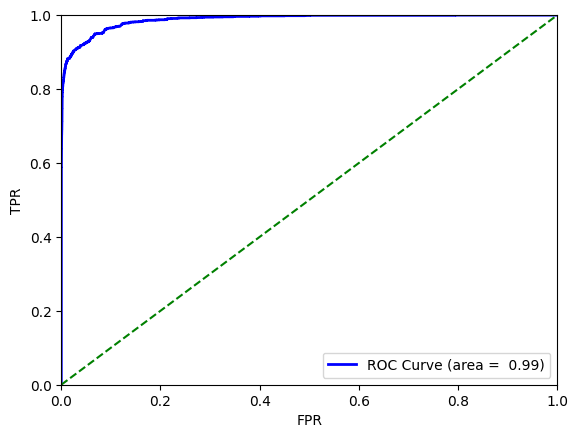

In [152]:
plt.plot(fpr , tpr , color = "blue" , lw = 2 , label = f"ROC Curve (area = {roc_auc : 0.2f})")
plt.plot([0 , 1] , [0 , 1] , "g--")

plt.xlim([0 , 1])
plt.ylim([0 , 1])

plt.ylabel("TPR")
plt.xlabel("FPR")
plt.legend()

plt.show()